In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

Model LSTM

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())
print(torch.version.cuda)
print(torch.cuda.get_device_name(0))

True
12.1
NVIDIA GeForce RTX 4060 Ti


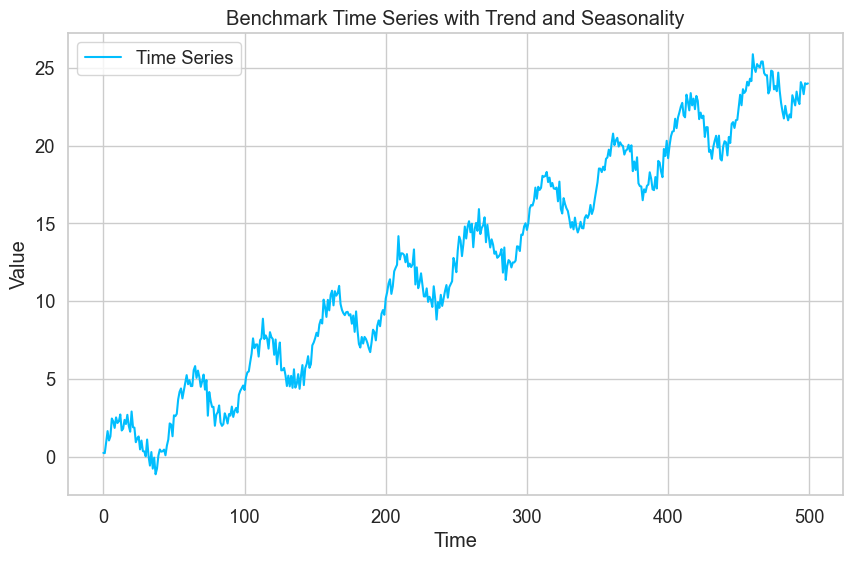

In [7]:
from functions_for_notebook import create_benchmark_data

%matplotlib inline
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

Colour_Palette = ["#01BEFE", "#FF7D00", "#FFDD00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(Colour_Palette))

n_points = 500
data, time_series, t = create_benchmark_data(n_points)


# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(data["Time"], data["Value"], label="Time Series")
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Benchmark Time Series with Trend and Seasonality")
plt.legend()
plt.show()

# Save the data to a CSV file
data.to_csv("benchmark_time_series.csv", index=False)

In [8]:
from functions_for_notebook import data_transformation

(
    train_data,
    test_data,
    scaled_train,
    scaled_test,
    dataset_train,
    dataset_test,
    scaler,
) = data_transformation(data, 0.8)

In [9]:
from functions_for_notebook import create_sequences

sequence_length = 50  # Number of time steps to look back
X_train, y_train = create_sequences(scaled_train, sequence_length)
X_test, y_test = create_sequences(scaled_test, sequence_length)

In [10]:
# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
print(X_train.shape, y_train.shape)

# Convert data to PyTorch tensors
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

torch.Size([350, 50, 1]) torch.Size([350, 1])


In [11]:
from models import LSTMModel

input_size = 1
num_layers = 3  # Increased number of layers
hidden_size = 128  # Increased number of hidden units
output_size = 1
dropout = 0.2  # Added dropout for regularization

model_lstm = LSTMModel(input_size, hidden_size, num_layers, dropout).to(device)
loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model_lstm.parameters(), lr=1e-3)  # Learning rate

In [12]:
model_lstm.to(device)

batch_size = 16  # Adjusted batch size

# Wraping in torch dataset data type
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

num_epochs = 100  # Increased number of epochs
train_hist = []
test_hist = []

for epoch in range(num_epochs):
    total_loss = 0.0
    model_lstm.train()
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        predictions = model_lstm(batch_X)
        loss = loss_fn(predictions, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    train_hist.append(average_loss)

    model_lstm.eval()
    with torch.no_grad():
        total_test_loss = 0.0

        for batch_X_test, batch_y_test in test_loader:
            batch_X_test, batch_y_test = (
                batch_X_test.to(device),
                batch_y_test.to(device),
            )
            predictions_test = model_lstm(batch_X_test)
            test_loss = loss_fn(predictions_test, batch_y_test)

            total_test_loss += test_loss.item()

        average_test_loss = total_test_loss / len(test_loader)
        test_hist.append(average_test_loss)

    if (epoch + 1) % 10 == 0:
        print(
            f"Epoch [{epoch + 1}/{num_epochs}] - Training Loss: {average_loss:.4f}, Test Loss: {average_test_loss:.4f}"
        )

Epoch [10/100] - Training Loss: 0.0027, Test Loss: 0.0198
Epoch [20/100] - Training Loss: 0.0024, Test Loss: 0.0138
Epoch [30/100] - Training Loss: 0.0017, Test Loss: 0.0141
Epoch [40/100] - Training Loss: 0.0012, Test Loss: 0.0128
Epoch [50/100] - Training Loss: 0.0010, Test Loss: 0.0096
Epoch [60/100] - Training Loss: 0.0012, Test Loss: 0.0089
Epoch [70/100] - Training Loss: 0.0008, Test Loss: 0.0086
Epoch [80/100] - Training Loss: 0.0010, Test Loss: 0.0083
Epoch [90/100] - Training Loss: 0.0008, Test Loss: 0.0074
Epoch [100/100] - Training Loss: 0.0008, Test Loss: 0.0081


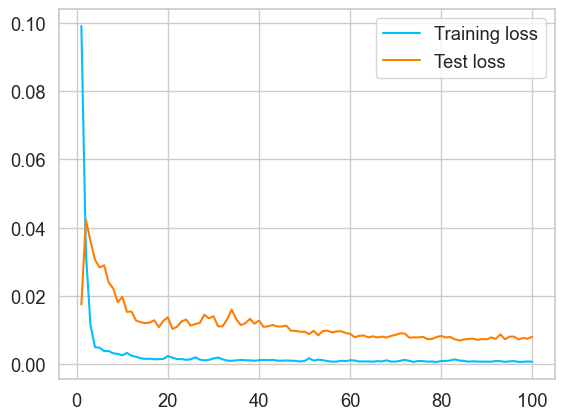

In [13]:
x = np.linspace(1, num_epochs, num_epochs)
plt.plot(x, train_hist, scalex=True, label="Training loss")
plt.plot(x, test_hist, label="Test loss")
plt.legend()
plt.show()

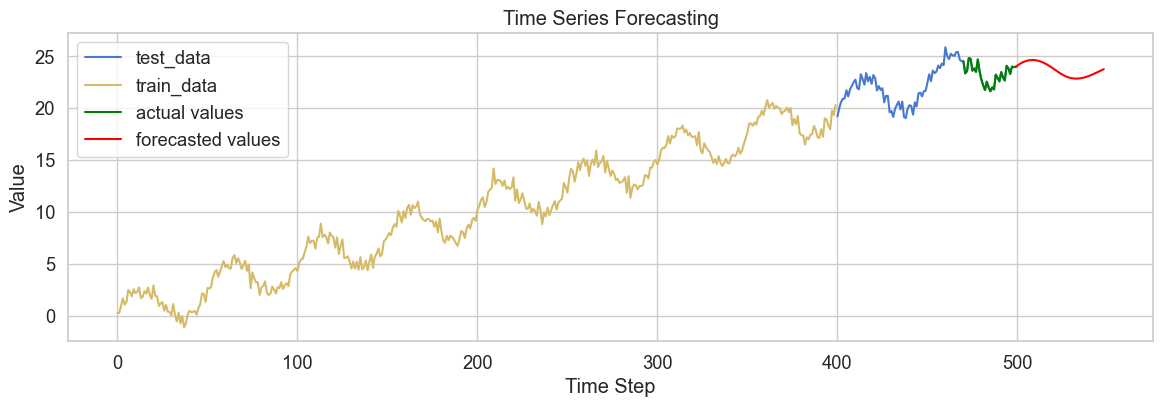

In [14]:
from functions_for_notebook import forecast_model_on_raw_data

forecasted_values = forecast_model_on_raw_data(
    model=model_lstm,
    device=device,
    data=data,
    num_forecast_steps=50,
    prediction_on=50,
    scaler=scaler,
)
last_number = test_data.index[-1]
periods = 49
future_dates = pd.Series(range(last_number, last_number + 1 + periods))

plt.rcParams["figure.figsize"] = [14, 4]
plt.plot(test_data.index, test_data.Value, label="test_data", color="b")
plt.plot(train_data.index, train_data.Value, label="train_data", color="y")
plt.plot(
    test_data.index[-30:], test_data.Value[-30:], label="actual values", color="green"
)
plt.plot(
    future_dates,
    scaler.inverse_transform(np.array(forecasted_values).reshape(-1, 1)).flatten(),
    label="forecasted values",
    color="red",
)

plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.title("Time Series Forecasting")
plt.grid(True)
plt.show()

# rmse, r2 = model_eval(model=model_lstm, X_test=X_test, y_test=y_test, device=device)

# print(f"RMSE: {rmse:.4f}")
# print(f"R² Score: {r2:.4f}")

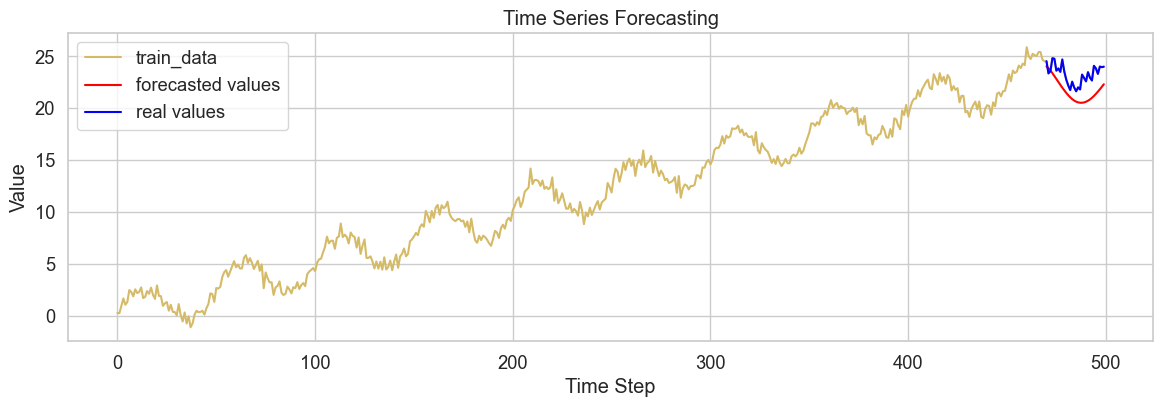

RMSE: 1.7555
R² Score: -2.7197


In [15]:
from functions_for_notebook import model_eval_raw_data, stats


historical_data, forecasted_values_scaled, real_values = model_eval_raw_data(
    model=model_lstm,
    data=data,
    device=device,
    prediction_start=80,
    prediction_end=30,
    scaler=scaler,
)
future_dates = data.index[-30:]


plt.plot(data.index, data.Value, label="train_data", color="y")
# plt.plot(historical_data.index, historical_data.Value, label="actual values", color="green")
plt.plot(
    future_dates,
    forecasted_values_scaled,
    label="forecasted values",
    color="red",
)
plt.plot(
    future_dates,
    real_values.Value,
    label="real values",
    color="blue",
)

plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.title("Time Series Forecasting")
plt.grid(True)
plt.show()

r2, rmse = stats(
    real_values=real_values.Value, test_predictions=forecasted_values_scaled
)

print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

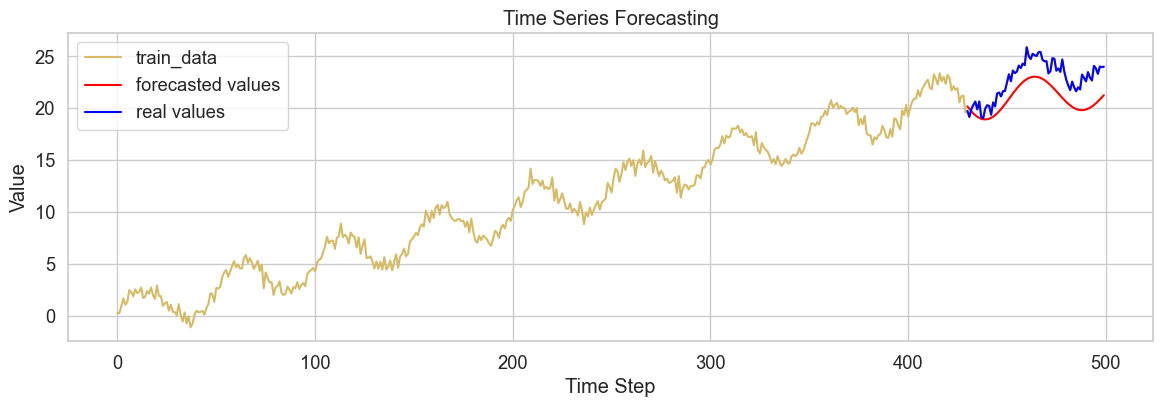

RMSE: 2.1147
R² Score: -0.3568


In [16]:
from functions_for_notebook import model_eval_raw_data, stats


historical_data, forecasted_values_scaled, real_values = model_eval_raw_data(
    model=model_lstm,
    data=data,
    device=device,
    prediction_start=120,
    prediction_end=70,
    scaler=scaler,
)
future_dates = data.index[-70:]


plt.plot(data.index, data.Value, label="train_data", color="y")
# plt.plot(historical_data.index, historical_data.Value, label="actual values", color="green")
plt.plot(
    future_dates,
    forecasted_values_scaled,
    label="forecasted values",
    color="red",
)
plt.plot(
    future_dates,
    real_values.Value,
    label="real values",
    color="blue",
)

plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.title("Time Series Forecasting")
plt.grid(True)
plt.show()

r2, rmse = stats(
    real_values=real_values.Value, test_predictions=forecasted_values_scaled
)

print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")